In [29]:
%matplotlib inline

In [30]:
# from numba import njit, jit, prange
import os
import numpy as np
import h5py
import mesocircuit.helpers.io as mio
import matplotlib.pyplot as plt
import scipy.signal as ss
import scipy.stats as st
import pandas as pd

In [31]:
time_step = 0.5
time_interval = [1000, 901000]

lag_max = 50
lag = np.linspace(-lag_max, lag_max, int(lag_max * 2 / time_step) + 1)

time_indices = np.arange(
    time_interval[0] / time_step,
    time_interval[1] / time_step).astype(int)

rootdir = '/p/scratch/cjinb33/hagen1/mesocircuit_data/upscaled_1mm2/b09dcfc3953647c1a29c007fe8dde5fa'
fpath = os.path.join(rootdir, 'processed_data/all_sptrains_bintime.h5')

# fpath = '/p/scratch/cjinb33/hagen1/mesocircuit_data/upscaled_1mm2/3be54d189b4f3a23c4859e0aea6b5fa8/processed_data/all_sptrains_bintime.h5'  # 5 min
# fpath = '/p/scratch/cjinb33/hagen1/mesocircuit_data/upscaled_1mm2/b09dcfc3953647c1a29c007fe8dde5fa/processed_data/all_sptrains_bintime.h5'  # 15 min
# fpath = '/p/scratch/cjinb33/hagen1/mesocircuit_data/reference/40049cd0c58ea46b08cecf6f8fa974eb/processed_data/all_sptrains_bintime.h5'

rates = {}
for X in ['L23E', 'L23I', 'L4E', 'L4I', 'L5E', 'L5I', 'L6E', 'L6I']:
    with h5py.File(fpath, 'r') as f:
        data = mio.load_h5_to_sparse_X(X, f)
    data
    # slice according to time interval
    num_neurons = data.shape[0]

    data = data[:, time_indices]

    # sum over neurons, divide by population size, and scale spike count to
    # instantaneous rate in spikes / s
    data = np.array(data.sum(axis=0)).ravel()
    data = data.astype(float) / num_neurons
    data = data / (time_step * 1e-3)
    data -= data.mean()
    data /= data.std()

    rates[X] = data

In [32]:
corrs = {}
for X, Y in zip(['L23E', 'L23E', 'L23I', 
                 'L4E', 'L4E', 'L4I', 
                 'L5E', 'L5E', 'L5I', 
                 'L6E', 'L6E', 'L6I'], 
                ['L23E', 'L23I', 'L23I', 
                 'L4E', 'L4I', 'L4I', 
                 'L5E', 'L5I', 'L5I', 
                 'L6E', 'L6I', 'L6I']):
    lag_inds = np.arange(data.size // 2 - lag_max / time_step, data.size // 2 + lag_max / time_step + 1).astype(int)
    corr = ss.correlate(rates[X], rates[Y], 'same')[lag_inds] / rates[X].size
    if X == Y:
        corr[lag_inds.size // 2] = np.nan
    corrs[f'{X}:{Y}'] = corr
corrs.keys()

dict_keys(['L23E:L23E', 'L23E:L23I', 'L23I:L23I', 'L4E:L4E', 'L4E:L4I', 'L4I:L4I', 'L5E:L5E', 'L5E:L5I', 'L5I:L5I', 'L6E:L6E', 'L6E:L6I', 'L6I:L6I'])

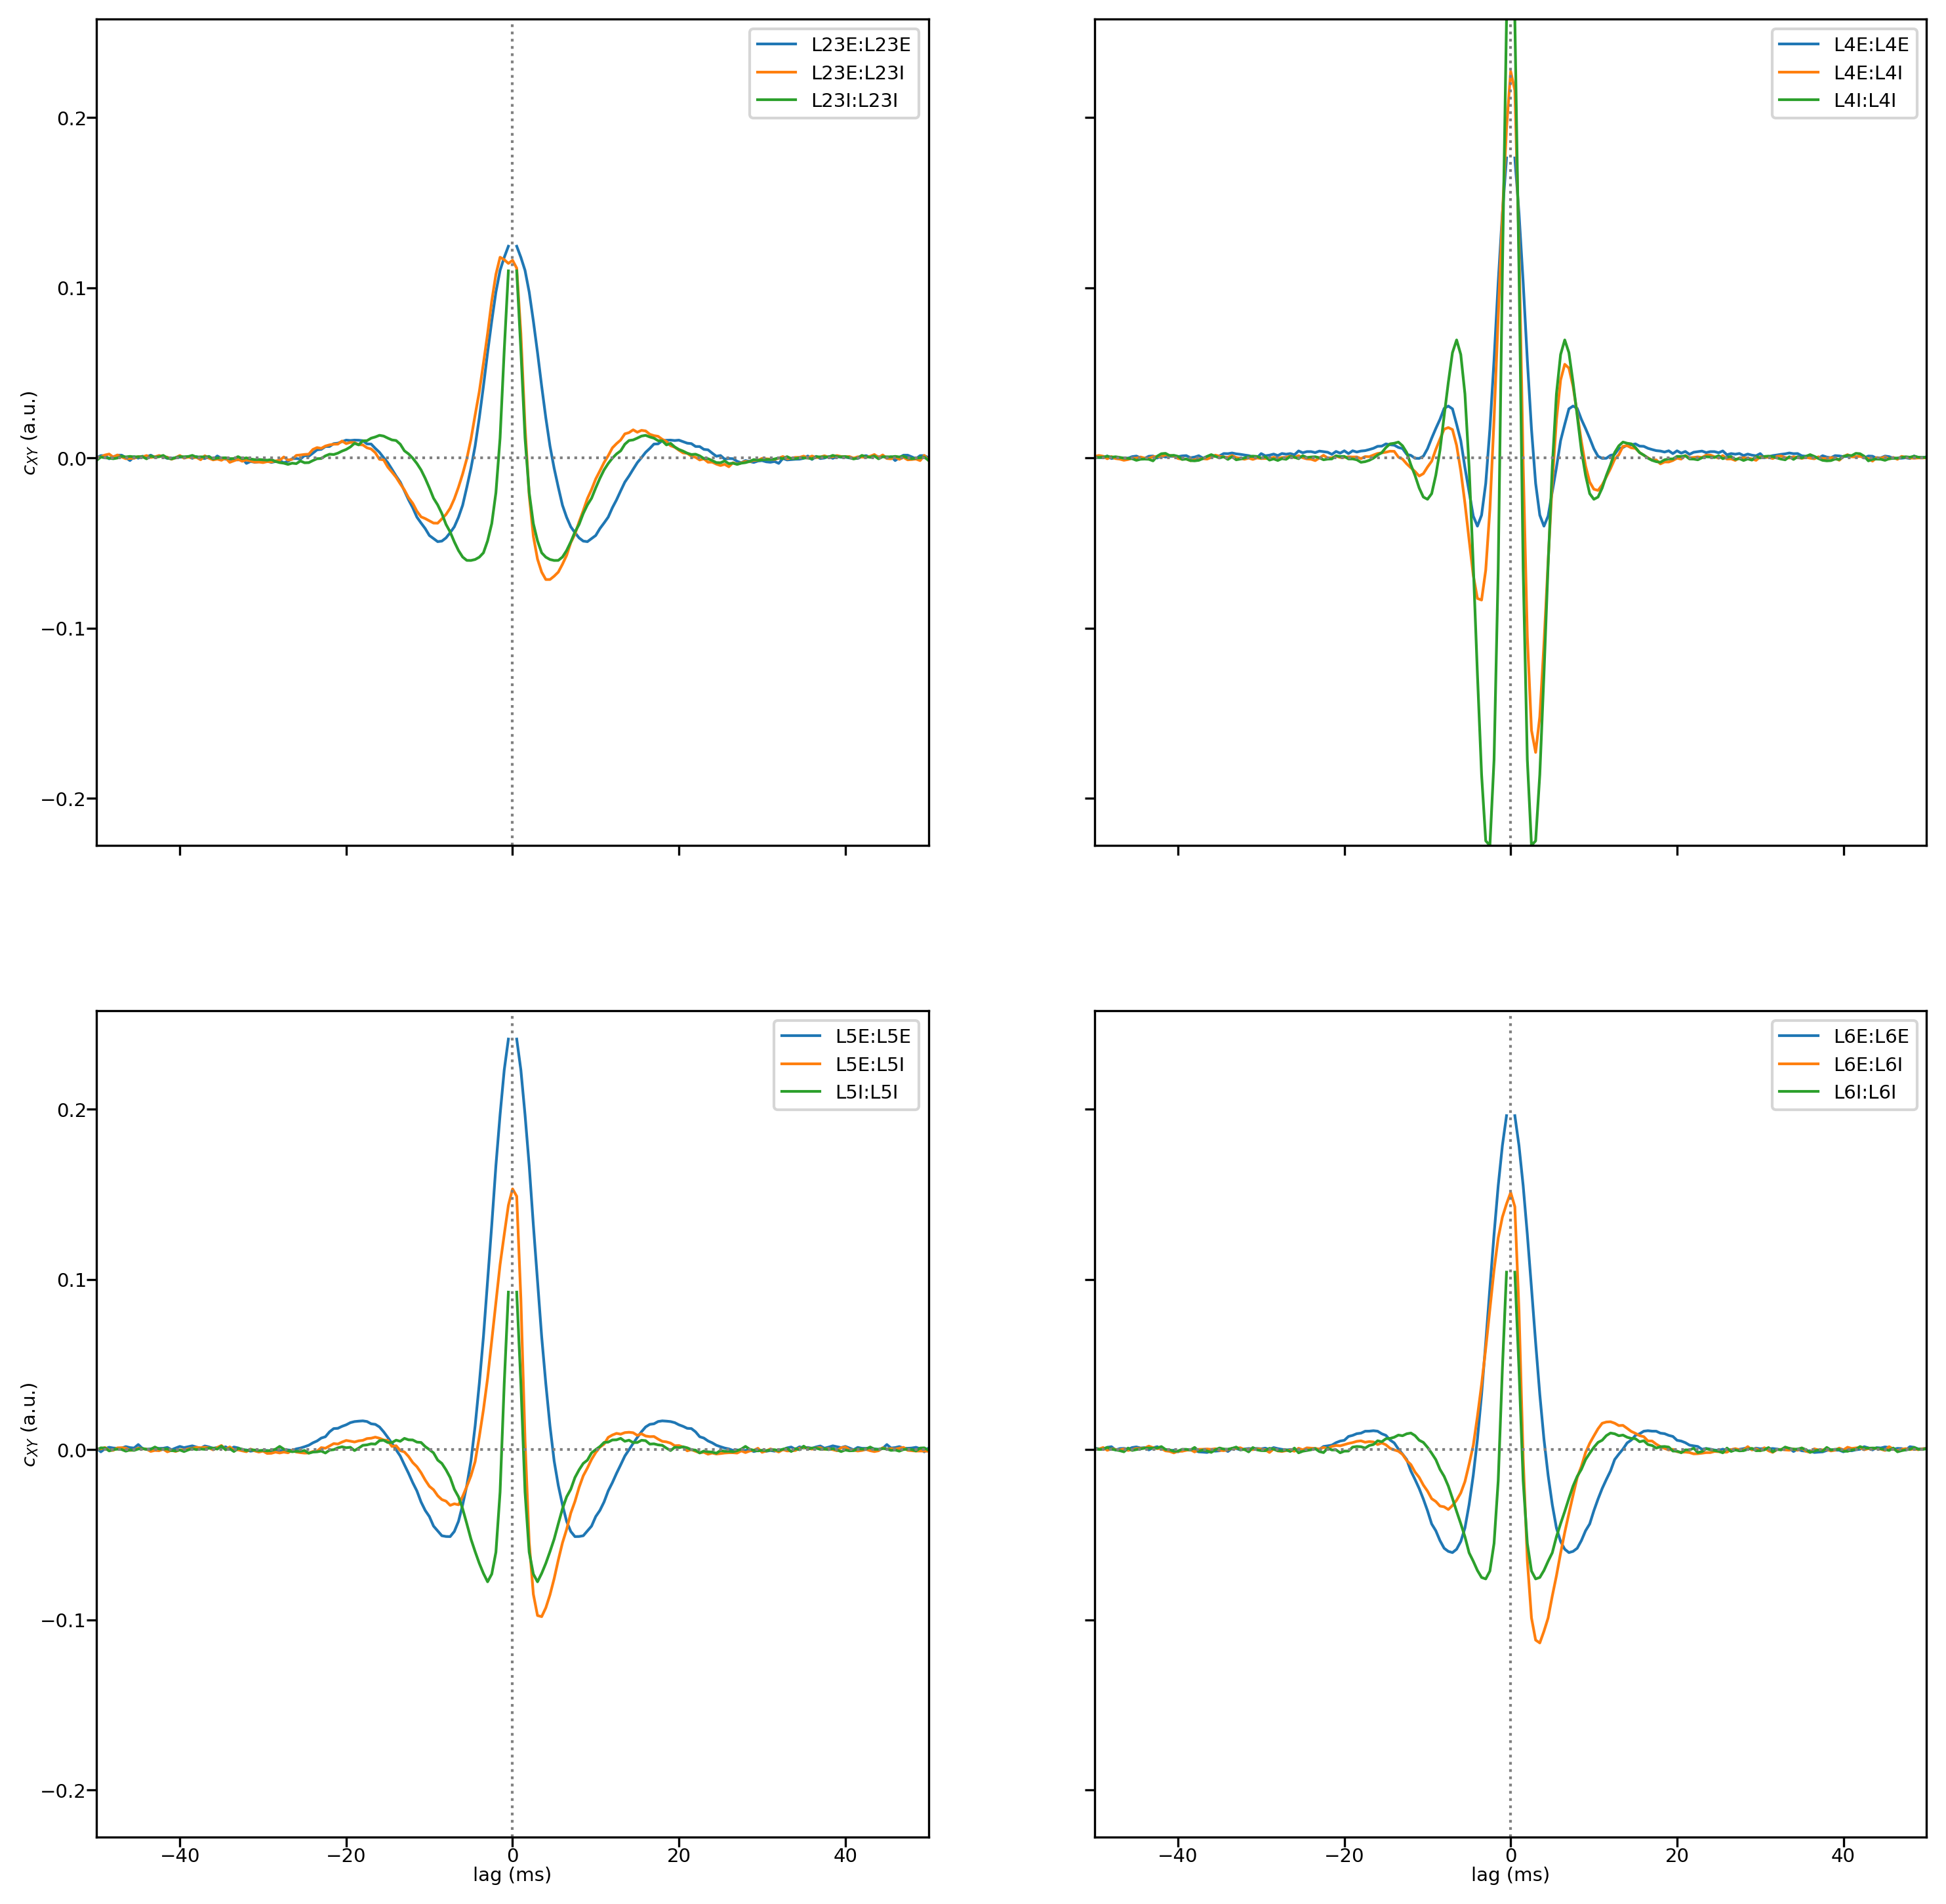

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True, sharex=True)
for i, (L, ax) in enumerate(zip(['L23', 'L4', 'L5', 'L6'], axes.flatten())):
    for key in [f'{L}E:{L}E', f'{L}E:{L}I', f'{L}I:{L}I']:
        ax.plot(lag, corrs[key], label=key)
    ax.axhline(y=0, color="grey", ls=':')
    ax.axvline(x=0, color="grey", ls=':')
    if i >= 2:
        ax.set_xlabel('lag (ms)')
    if i % 2 == 0:
        ax.set_ylabel('$c_{XY}$ (a.u.)')
    ax.legend()

ax.axis(ax.axis('tight'))

fig.savefig('rate_correlations.png', dpi=300)


In [34]:
# pairwise spike trains ignoring autocorrelations
n_trains = 512
# time_interval = [1000, 21000]
time_indices = np.arange(
    time_interval[0] / time_step,
    time_interval[1] / time_step).astype(int)

# prep some reshaping to temporally resample
# q = int(1 / time_step)
q = int(2 / time_step)  # compute correlation functions using bin size 2 ms

sptrains = {}
for X in ['L23E', 'L23I', 'L4E', 'L4I', 'L5E', 'L5I', 'L6E', 'L6I']:
    with h5py.File(fpath, 'r') as f:
        data = mio.load_h5_to_sparse_X(X, f)

    # slice according to time interval
    data = data[:n_trains, time_indices]

    # scale spike count to
    # instantaneous rate in spikes / s
    data = data.toarray().astype(float)

    # downsample summing every q column
    data = data.reshape((data.shape[0], data.shape[1] // q, q)).sum(axis=-1)

    data = data / (time_step * q * 1e-3)
    data = ((data.T - data.mean(axis=1)) / data.std(axis=1)).T

    sptrains[X] = data

In [35]:
# compute correlation functions in parallel
# import multiprocessing
from joblib import Parallel, delayed

def get_spike_correlations(sptrains_X, sptrains_Y, lag_inds, num_cores=1):
    n_trains = sptrains_X.shape[0]
    mask = np.tri(n_trains, k=0) != True
    def corr(ij, sptrains_X, sptrains_Y, lag_inds):
        return ss.correlate(sptrains_X[ij[0]], sptrains_Y[ij[1]], 'same')[lag_inds] / sptrains_X[ij[0]].size
    
    spcorrs = Parallel(n_jobs=num_cores)(delayed(corr)(ij, sptrains_X, sptrains_Y, lag_inds) for ij in np.c_[np.where(mask)])

    return np.array(spcorrs)

In [36]:
with h5py.File(os.path.join(rootdir, 'processed_data/correlation_functions.h5'), 'r') as f:
    spcorrs_all = {}
    spcorrs_all_std = {}
    for X, Y in zip(['L23E', 'L23E', 'L23I', 
                    'L4E', 'L4E', 'L4I', 
                    'L5E', 'L5E', 'L5I', 
                    'L6E', 'L6E', 'L6I'], 
                    ['L23E', 'L23I', 'L23I', 
                    'L4E', 'L4I', 'L4I', 
                    'L5E', 'L5I', 'L5I', 
                    'L6E', 'L6I', 'L6I']):

        spcorrs_all[f'{X}:{Y}'] = f[f'{X}:{Y}'][()].mean(axis=0)
        spcorrs_all_std[f'{X}:{Y}'] = f[f'{X}:{Y}'][()].std(axis=0)

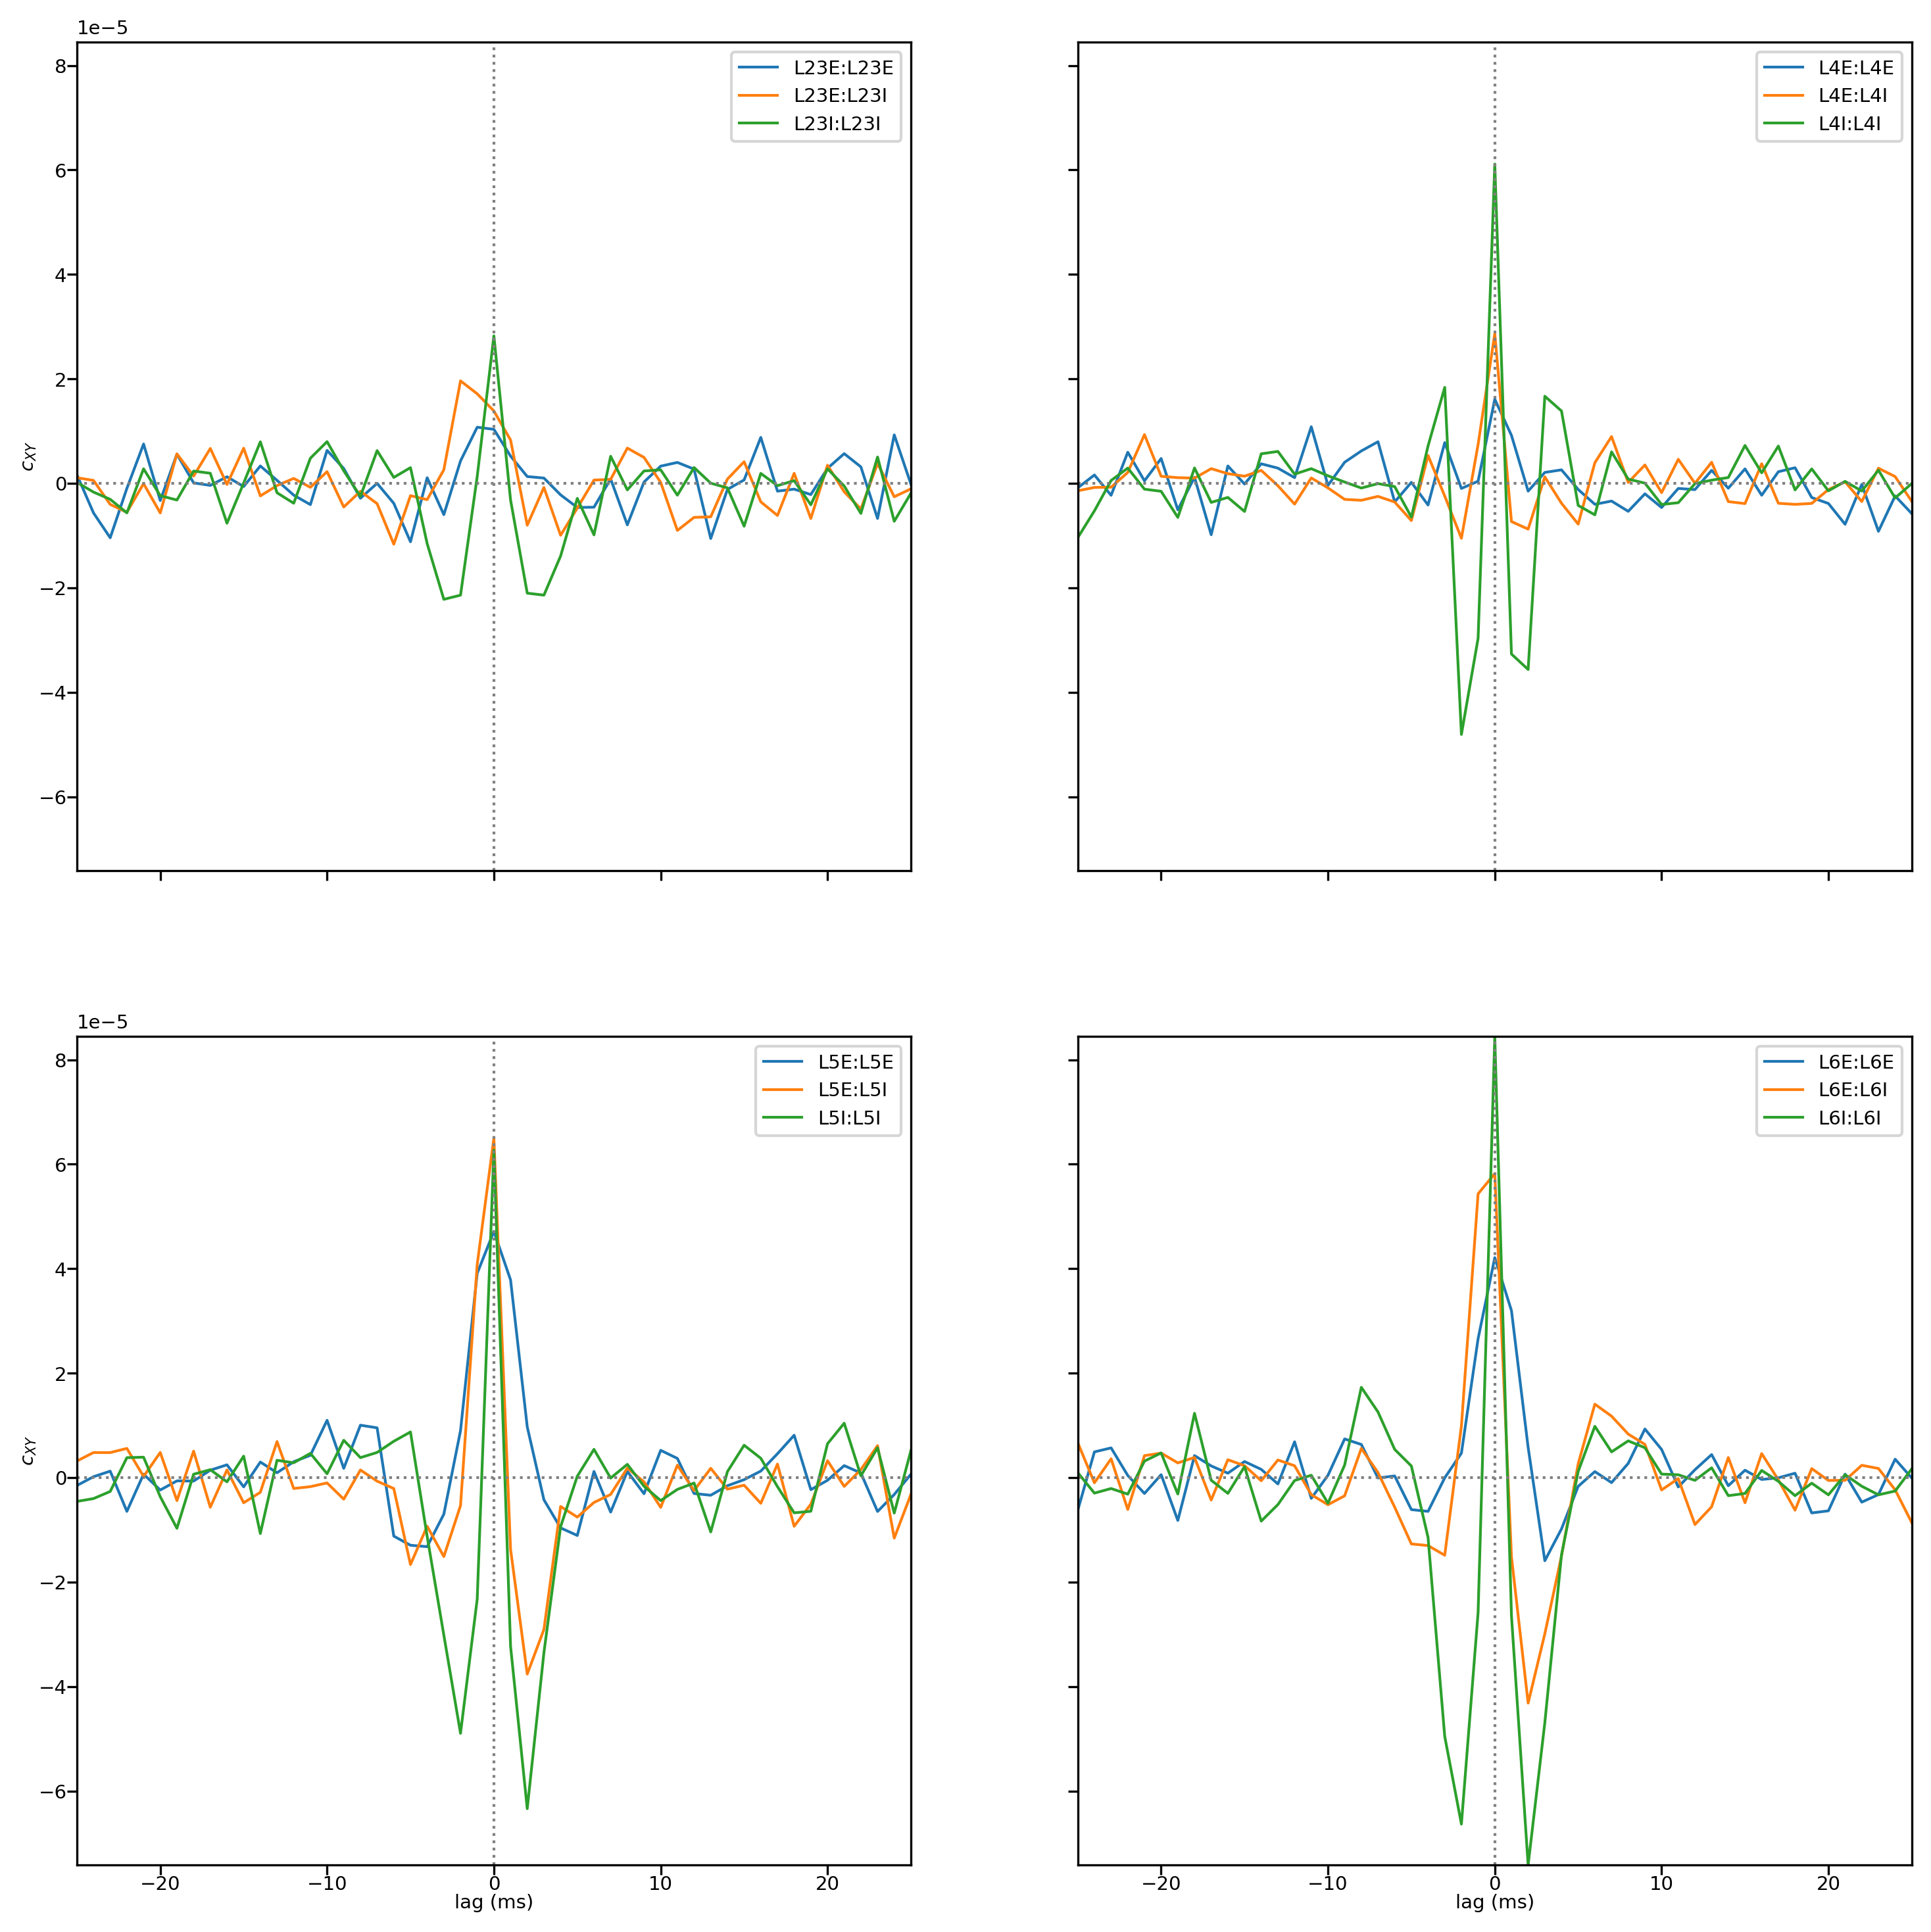

In [37]:
lag_inds = np.arange(spcorrs_all[f'{X}:{Y}'].shape[0])
lags = (lag_inds - lag_inds.size // 2)
inds = (lags >= -lag_max) & (lags <= lag_max)

fig, axes = plt.subplots(2, 2, figsize=(12, 12), sharex=True, sharey=True)
for i, (L, ax) in enumerate(zip(['L23', 'L4', 'L5', 'L6'], axes.flatten())):
    for key in [f'{L}E:{L}E', f'{L}E:{L}I', f'{L}I:{L}I']:
        ax.plot(lags[inds], spcorrs_all[key][inds], label=key)

    ax.axhline(y=0, color="grey", ls=':')
    ax.axvline(x=0, color="grey", ls=':')
    ax.legend()
    if i >= 2:
        ax.set_xlabel('lag (ms)')
    if i % 2 == 0:
        ax.set_ylabel('$c_{XY}$')

    ax.axis(ax.axis('tight'))

fig.savefig('spiketrain_correlations.png', dpi=300)

### pairwise correlation coefficients for different bin sizes

In [38]:
from mesocircuit.parameterization.base_analysis_params import ana_dict
from mesocircuit.plotting.plotting import plot_boxcharts
from mesocircuit.parameterization.base_plotting_params import plot_dict
from matplotlib.gridspec import GridSpec


fpath = os.path.join(rootdir, 'processed_data/all_CCs_distances.h5')

all_CCs_distances = h5py.File(fpath, 'r')

try:
    all_CCS_time_interval = {}
    for ccs_time_interval in iter(ana_dict['ccs_time_interval']):
        all_CCs = {}
        for X in all_CCs_distances:
            if X == 'TC':
                continue
            if isinstance(all_CCs_distances[X], h5py._hl.group.Group):
                all_CCs[X] = all_CCs_distances[X][f'ccs_{ccs_time_interval}']
            else:
                all_CCs[X] = np.array([])
        all_CCS_time_interval[f'{ccs_time_interval}'] = all_CCs
except TypeError as _:
    all_CCs = {}
    for X in all_CCs_distances:
        if X == 'TC':
            continue
        if isinstance(all_CCs_distances[X], h5py._hl.group.Group):
            all_CCs[X] = all_CCs_distances[X][f'ccs_{ana_dict["ccs_time_interval"]}']
        else:
            all_CCs[X] = np.array([])



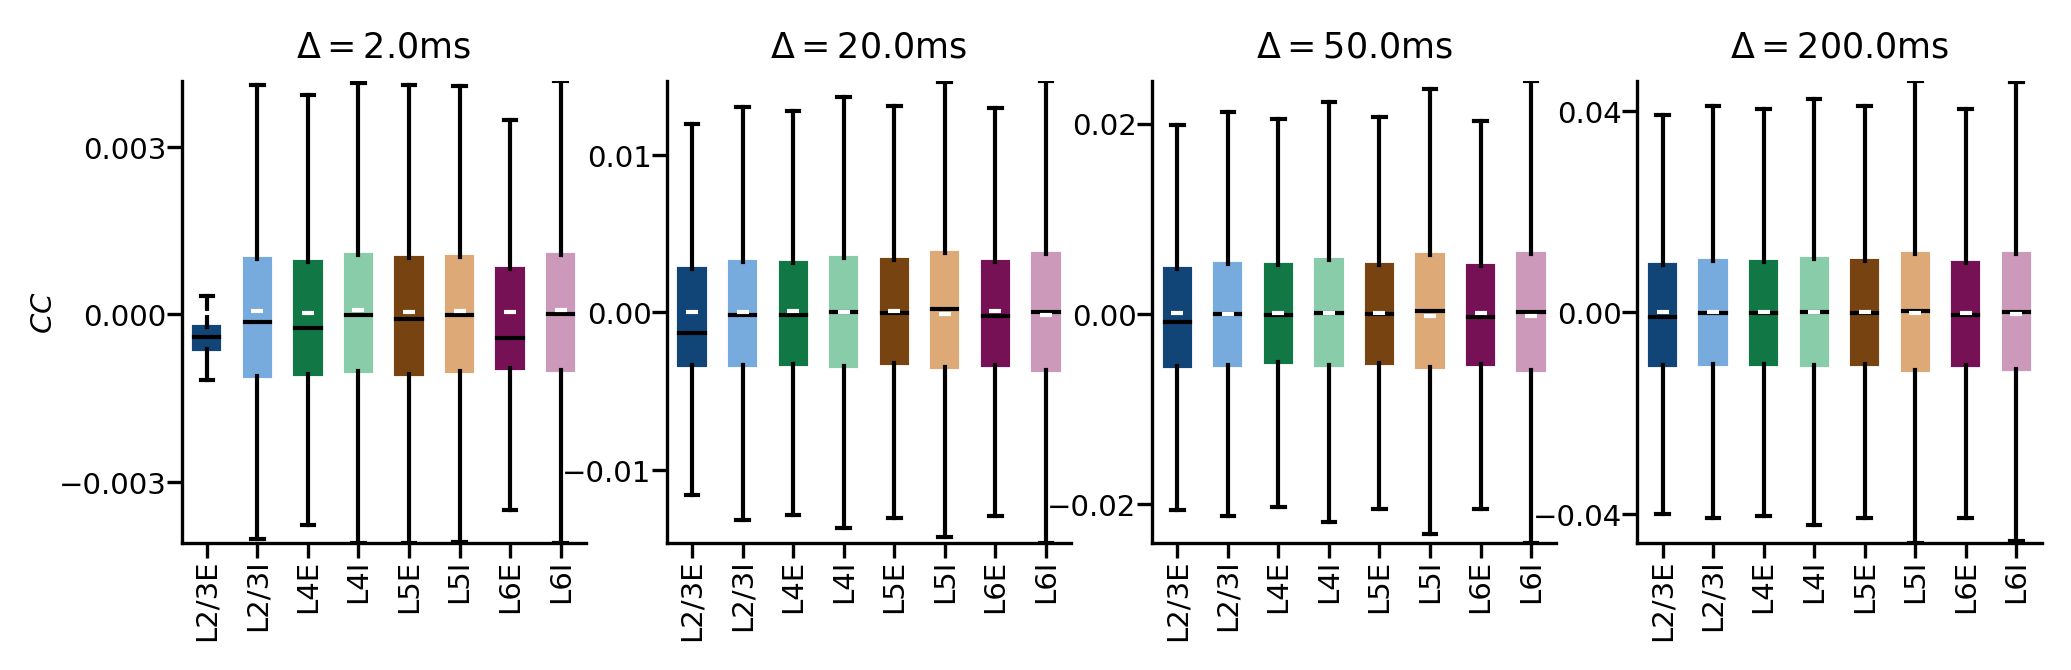

In [39]:
gs = GridSpec(1, len(ana_dict['ccs_time_interval']))
fig = plt.figure(figsize=(2 * len(ana_dict['ccs_time_interval']), 2))

axes = []
for i, ccs_time_interval in enumerate(iter(ana_dict['ccs_time_interval'])):
    ax = plot_boxcharts(gs[i],
                        all_CCS_time_interval[f'{ccs_time_interval}'],
                        list(all_CCs.keys()),
                        pop_labels=plot_dict['pop_labels'],
                        pop_colors=plot_dict['pop_colors'],
                        xlabel='', ylabel=r'$CC$',
                        ylims=False)
    ax.axis(ax.axis('tight'))
    if i != 0:
        ax.set_ylabel('')
    ax.set_title(r'$\Delta={%.1f}\mathrm{ms}$' % ccs_time_interval)
    axes.append(ax)
    

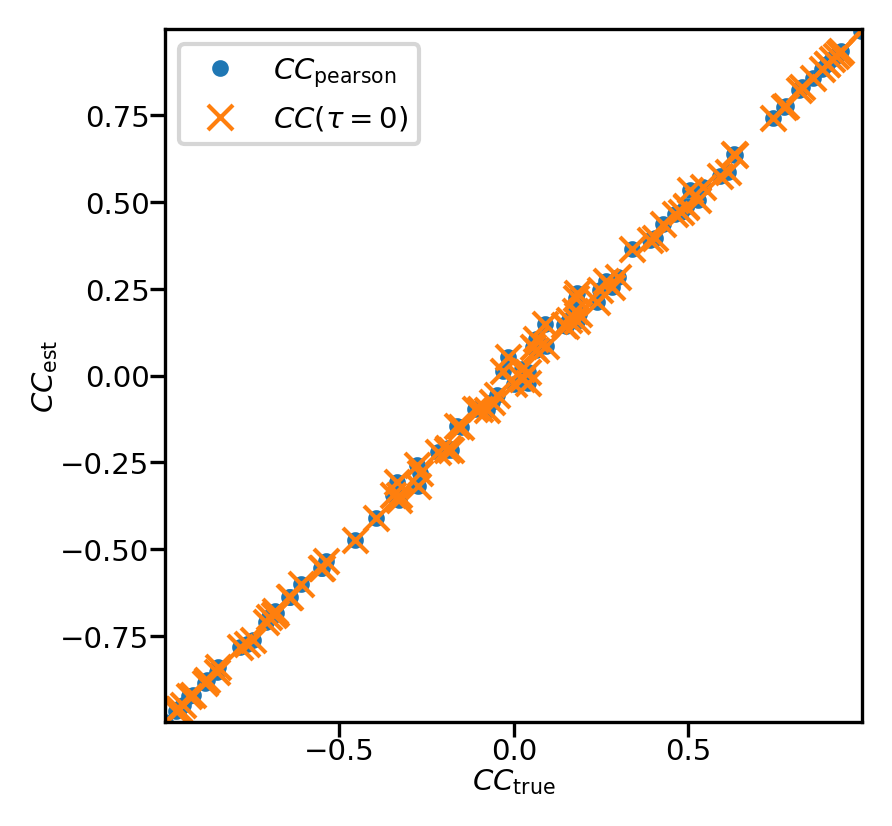

In [40]:
# Zero time lag correlation corresponds to pearson correlation coefficient
CCs = np.random.rand(100)
CCs = CCs * 2 - 1
CCs_pearson = []
CCs_0lag = []
def zt(u):
    return (u - u.mean()) / u.std()
for cc in CCs:
    x = zt(np.random.randn(1000))
    y = zt(np.random.randn(1000))
    z = zt(np.random.randn(1000))

    x = x * np.sqrt(1 - abs(cc)) + np.sqrt(abs(cc)) * z
    y = y * np.sqrt(1 - abs(cc)) + np.sqrt(abs(cc)) * np.sign(cc) * z

    x /= x.std()
    y /= y.std()

    CCs_pearson.append(np.corrcoef(zt(x), zt(y))[1, 0])

    CCs_0lag.append(ss.correlate(x, y, 'same')[x.size // 2] / x.size)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(CCs, CCs_pearson, '.', label=r'$CC_\mathrm{pearson}$')
ax.plot(CCs, CCs_0lag, 'x', label='$CC(\\tau=0)$')
ax.set_xlabel(r'$CC_\mathrm{true}$')
ax.set_ylabel(r'$CC_\mathrm{est}$')
plt.legend()


### Check that integral over correlation function correlates with pearson correlation coefficient

In [47]:
X = 'L6E'
Y = 'L6I'
with h5py.File(os.path.join(rootdir, 'processed_data/correlation_functions.h5'), 'r') as f:
    corrfuns = f[f'{X}:{Y}'][()]


dt_0 = 1
dt_1 = 5
q = int(dt_1 // dt_0)

data = np.r_[sptrains[X], sptrains[Y]]

mask = np.tri(data.shape[0], k=sptrains[X].shape[0]) == 0

# downsample summing every q column
data = data.reshape((data.shape[0], data.shape[1] // q, q)).sum(axis=-1)

data = data / (time_step * q * 1e-3)
data = ((data.T - data.mean(axis=1)) / data.std(axis=1)).T

# pearson correlation coefficient
cc_pearson = np.corrcoef(data)[mask].flatten()

# by integrating correlation function
inds = np.arange(corrfuns.shape[1] // 2 - q + 1, corrfuns.shape[1] // 2 + q)
if inds.size == 1:
    cc_corrfun = corrfuns[:, inds[0]]
else:
    cc_corrfun = corrfuns[:, inds].sum(axis=1)

Text(0, 0.5, 'corrfun')

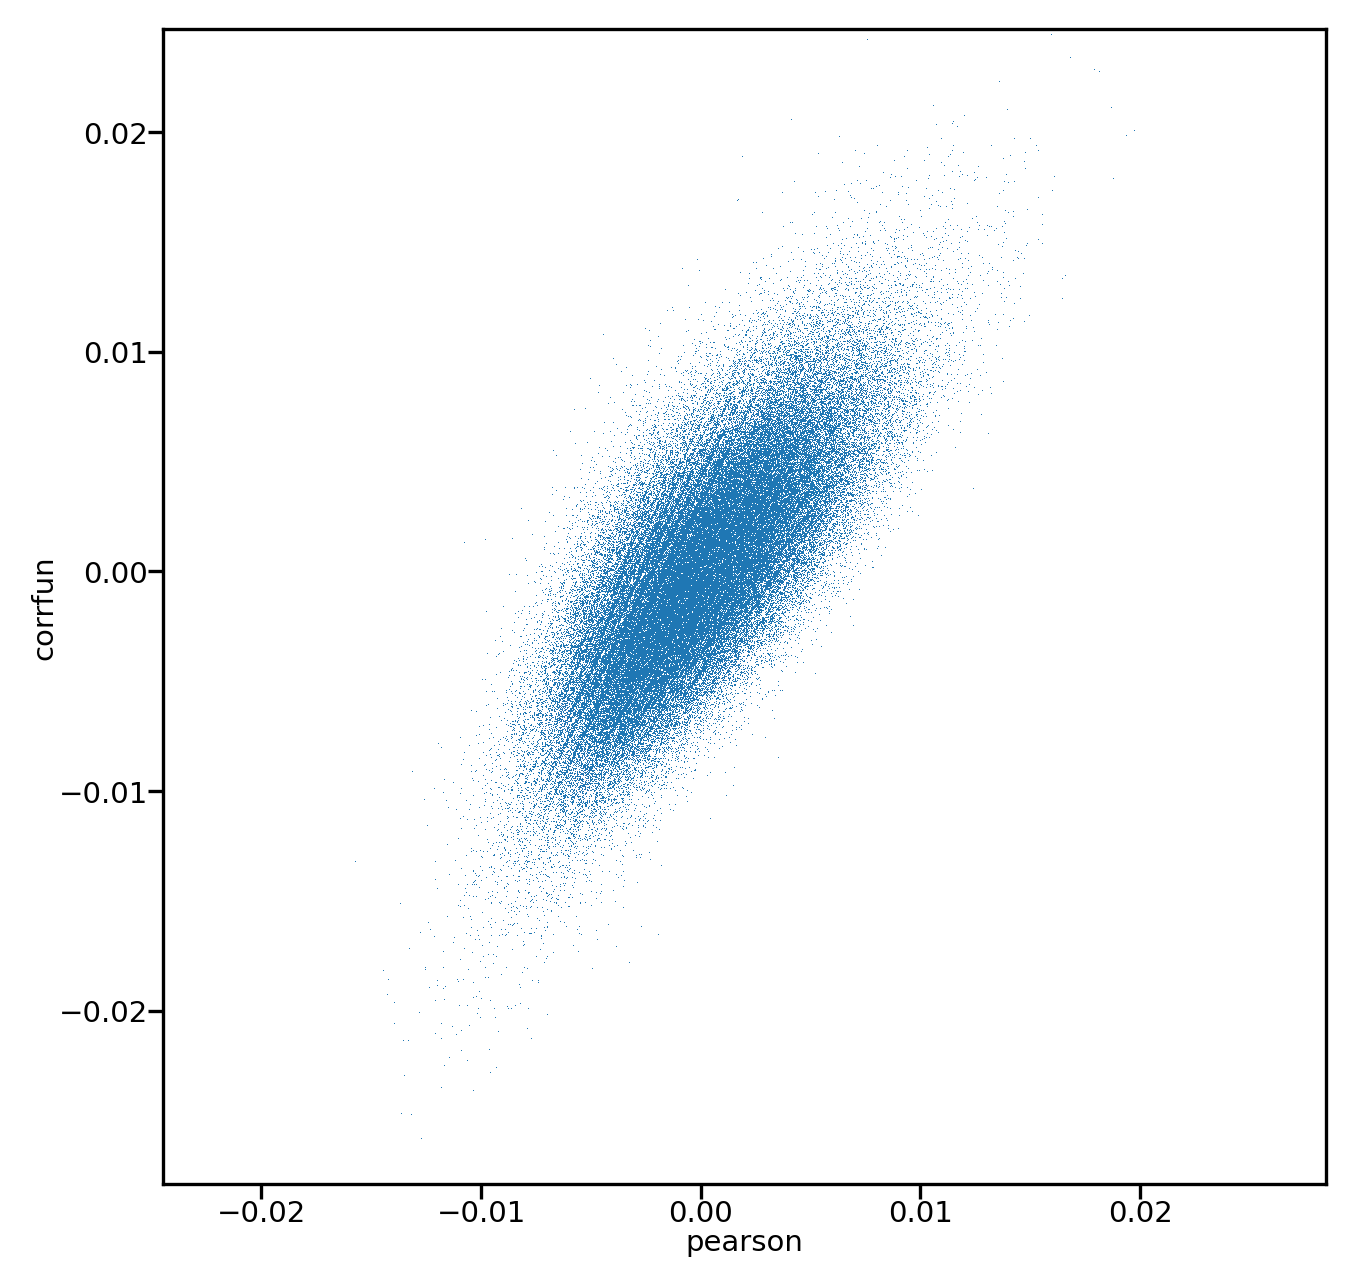

In [48]:
plt.figure(figsize=(5, 5))
plt.plot(cc_pearson, cc_corrfun, ',')
plt.axis('equal')
plt.xlabel('pearson')
plt.ylabel('corrfun')

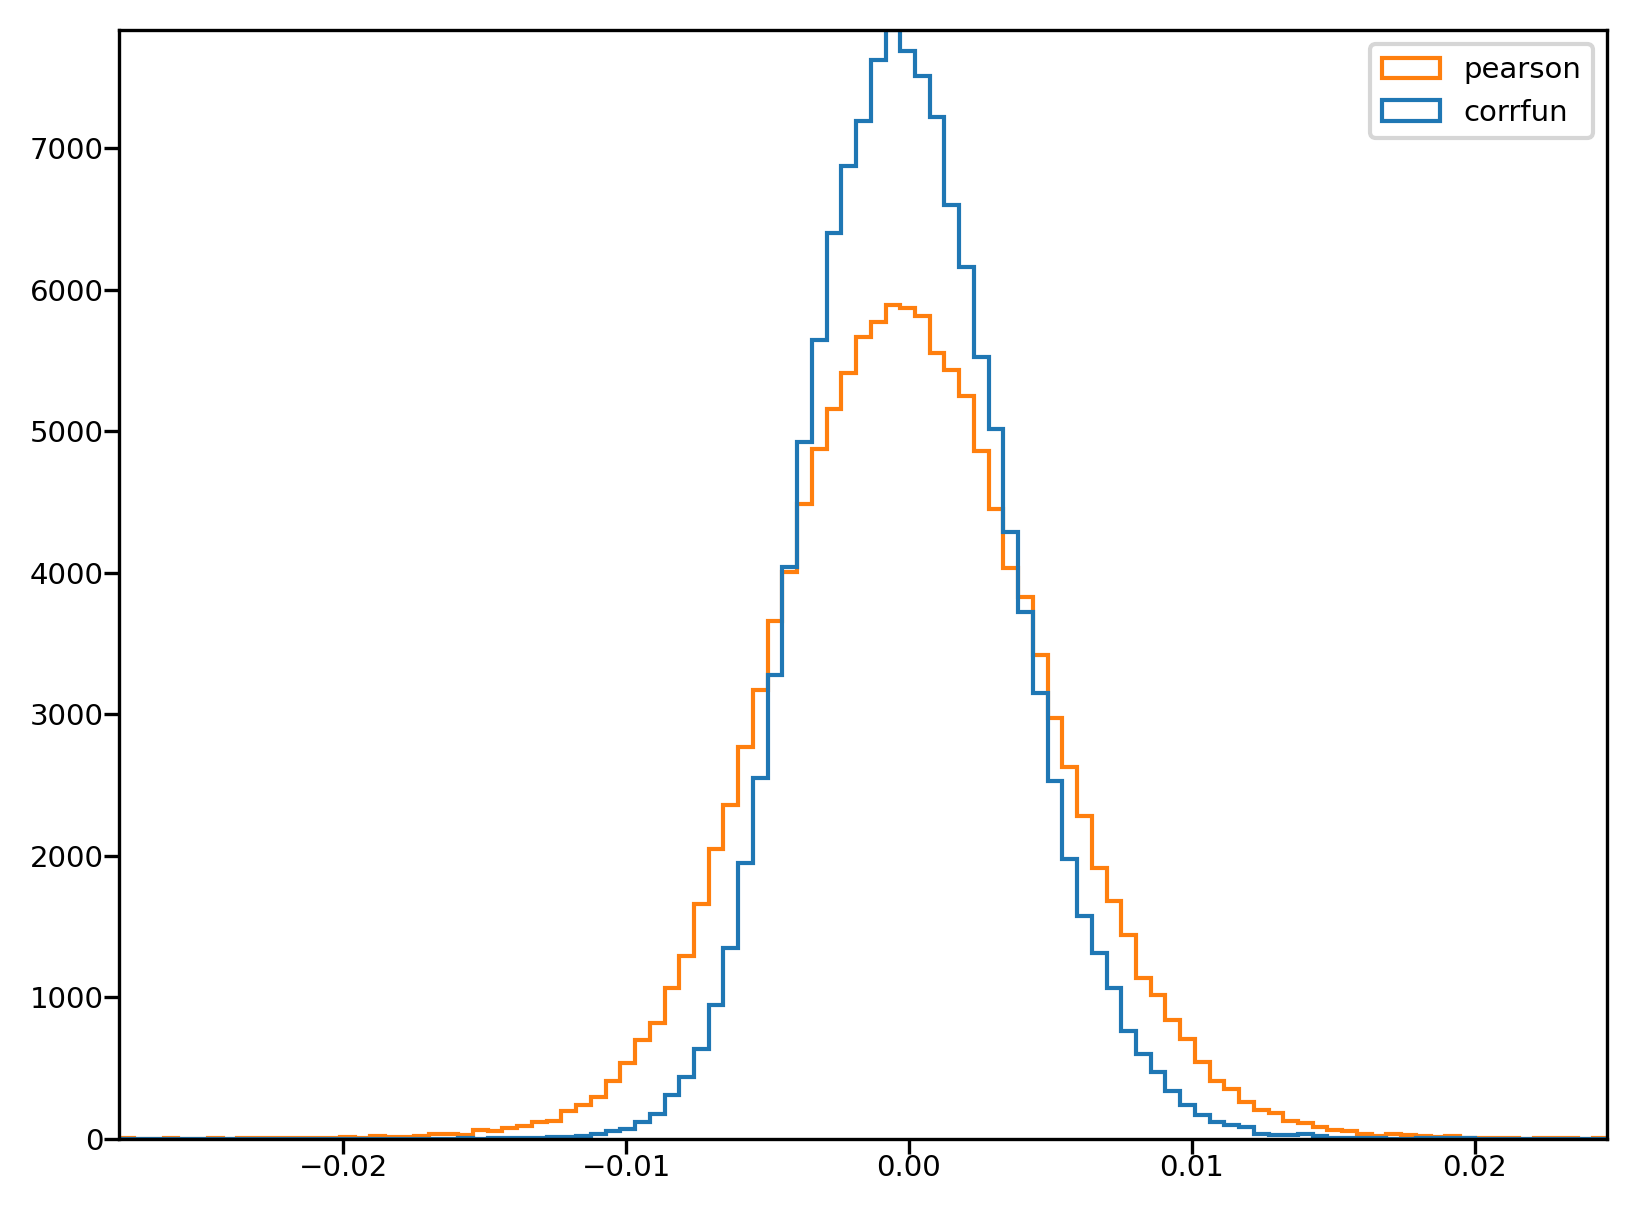

In [49]:
plt.hist([cc_pearson, cc_corrfun], bins=101, histtype='step')
plt.legend(['pearson', 'corrfun'])